In [1]:
import pandas as pd
import pickle

#omega = pd.read_csv('../baypass_terminal/omegaavg_wheader_first_gen.txt',sep='\t').set_index('Unnamed: 0')

#omega.to_csv('omega.csv', header=None, index=None)

import statsmodels.api as sm
from statsmodels.formula.api import glm

from sklearn.preprocessing import StandardScaler


import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
biovar = 'bio1'

In [3]:
#finalgen_samples = pd.read_csv('../final_gen.csv')['sample_name']
first_gen_samples = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]

samples = first_gen_samples.to_list()

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

In [4]:
env_variable = env[biovar]

In [5]:
# Standardize the environmental variable
scaler = StandardScaler()
env_variable_scaled = scaler.fit_transform(env_variable.values.reshape(-1, 1))

In [6]:
pd.DataFrame(env_variable_scaled).to_csv(f'env_{biovar}.csv',index=None)

In [45]:
env_variable = pd.read_csv(f'env_{biovar}.csv')

In [46]:
partition_0 = pd.read_csv('../baypass_first_gen/individual_gfiles/partition_0.txt',header=None) #= pd.read_csv(path_analysis + 'individual_gfiles/partition_0.txt',header=None)

In [47]:
pickle_file_path = '../baypass_first_gen/individual_gfiles/column_names_partition_0'
with open(pickle_file_path, 'rb') as file:
    data0 = pickle.load(file)

In [48]:
partition_0.columns = data0

In [49]:
minor_columns = partition_0.filter(like='minor')
major_columns = partition_0.filter(like='major')

In [50]:
# Properly calculate total allele counts by summing corresponding minor and major allele counts
total_allele_counts = minor_columns.values + major_columns.values

# Create a new DataFrame for total counts with proper column names
total_allele_counts_df = pd.DataFrame(total_allele_counts, columns=minor_columns.columns.str.replace('_minor', '_total'))

In [51]:

# Preparing data for binomial regression
# Minor allele counts as the response variable (successes)
minor_alleles = minor_columns.T.reset_index(drop=True)
major_columns = major_columns.T.reset_index(drop=True)

# Total allele counts as the number of trials (total attempts)
total_alleles = total_allele_counts_df.T.reset_index(drop=True)


In [52]:
successes = minor_alleles.iloc[:,1]
failures = major_columns.iloc[:,1]

In [53]:
# Running binomial regression for each SNP separately
coefficients_df = {}

for i in range(minor_alleles.shape[1]):
    # Prepare response (successes, failures) and predictors (environmental variable)
    successes = minor_alleles.iloc[:,i]
    failures = major_columns.iloc[:,i]
    # Set up the binomial regression model
    X = sm.add_constant(env_variable)  # Adding constant for intercept
    y = pd.concat([successes,failures],axis=1)
    # Fit the modelb
    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()

    # Extract slope (coefficient for environmental variable) and p-value
    slope = result.params[1]  # Coefficient for the environmental variable
    p_value = result.pvalues[1]  # P-value for the environmental variable
    
    # Append the results to the DataFrame
    coefficients_df[i] = [slope, p_value]
    
    # Collect resul


KeyboardInterrupt



In [ ]:
coefficients_df = pd.DataFrame(coefficients_df).T

In [ ]:
coefficients_df.columns = ['slope', 'pvalue']

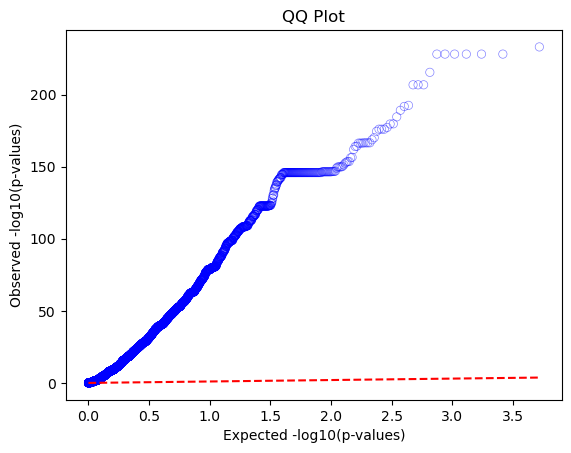

In [129]:
observed_quantiles = -np.log10(np.sort(coefficients_df['pvalue'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(coefficients_df['pvalue']), 1, len(coefficients_df['pvalue'])))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot')

plt.show()

In [117]:
coefficients_df['pvalue'].unique()

array([8.17162954e-01, 8.58518224e-05, 1.85612522e-01, ...,
       1.08041784e-20, 7.42600016e-24, 5.29329426e-04])

In [84]:
result.params

const    7.960043e+17
x1      -9.474735e+16
dtype: float64

In [27]:
partition_0.to_csv('sample_allele_counts.csv',index=None)

In [81]:
import os

In [82]:
files = os.listdir('../baypass_first_gen/individual_gfiles/')

In [83]:
partitions = [int(file.split('_')[1].replace('.txt', '')) for file in files if '.txt' in file]

In [84]:
partitions.sort()

In [85]:
partitions[-1]

201

In [8]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/binomial_regression'

In [9]:
## create testing (which is actually all teh sites to predict them)

In [13]:
test = clim_sites_during_exp[['site', 'bio1']].copy()

In [14]:
# Standardize the environmental variable
scaler = StandardScaler()
env_variable_scaled = scaler.fit_transform(test['bio1'].values.reshape(-1, 1))

In [16]:
test['bio1'] = env_variable_scaled

In [32]:
test.columns = ['site', 'env_scaled']

In [33]:
test.to_csv('env_scaled_test.csv',index=None)

In [34]:
#env_site_scaled = pd.read_csv('../binomial_regression_firstgen_go/env_site_scaled.csv')

In [ ]:
env_site_scaled = pd.read_csv('env_scaled_test.csv')

test_sites = env_site_scaled['site'].unique()

In [77]:
import random
import subprocess

In [78]:
env_variable = pd.read_csv(f'env_{biovar}.csv')

In [79]:
biovar = 'bio1'

In [99]:
# create sbatch files to submit on cedar server
shfiles = []
for partition in partitions:
    seed = random.randint(1,100000000)
    file = f'shfiles/partition_{partition}.sh'
    cmd = f'python run_partition_binomial_reg_predict.py {partition} {biovar}'
    text = f'''#!/bin/bash
#SBATCH --job-name=run_partition_binomial_reg{partition}
#SBATCH --time=4:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=run_partition_binomial_reg{partition}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/binomial_regression
{cmd}

'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [87]:
subprocess.run(["sbatch", shfiles[0]], check=True)

Submitted batch job 66185


CompletedProcess(args=['sbatch', 'shfiles/partition_0.sh'], returncode=0)

In [100]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 66186
Submitted batch job 66187
Submitted batch job 66188
Submitted batch job 66189
Submitted batch job 66190
Submitted batch job 66191
Submitted batch job 66192
Submitted batch job 66193
Submitted batch job 66194
Submitted batch job 66195
Submitted batch job 66196
Submitted batch job 66197
Submitted batch job 66198
Submitted batch job 66199
Submitted batch job 66200
Submitted batch job 66201
Submitted batch job 66202
Submitted batch job 66203
Submitted batch job 66204
Submitted batch job 66205
Submitted batch job 66206
Submitted batch job 66207
Submitted batch job 66208
Submitted batch job 66209
Submitted batch job 66210
Submitted batch job 66211
Submitted batch job 66212
Submitted batch job 66213
Submitted batch job 66214
Submitted batch job 66215
Submitted batch job 66216
Submitted batch job 66217
Submitted batch job 66218
Submitted batch job 66219
Submitted batch job 66220
Submitted batch job 66221
Submitted batch job 66222
Submitted batch job 66223
Submitted ba

In [63]:
biovar

'bio18'

In [103]:
loci_names = [file for file in files if 'loci' in file]

In [104]:
partition = 0 

In [105]:
pickle_file_path = f'../baypass_first_gen/individual_gfiles/loci_partition_{partition}'
with open(pickle_file_path, 'rb') as file:
    loci_f = pickle.load(file)

In [109]:
partitions_r = {}
for i in range(len(partitions)):
    pickle_file_path = f'../baypass_first_gen/individual_gfiles/loci_partition_{i}'
    with open(pickle_file_path, 'rb') as file:
        loci_f = pickle.load(file)
    results = pd.read_csv(f'results_{biovar}/split_{i}/prediction_sites.csv')
    print(len(loci_f) == len(results))
    results['snp_id'] = loci_f
    partitions_r[i] = results

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [110]:
results = pd.concat(partitions_r).reset_index(drop=True)

In [111]:
results

,snp,slope,pvalue,intercept,pred_proba_1,pred_proba_2,pred_proba_3,pred_proba_4,pred_proba_5,pred_proba_6,...,pred_proba_51,pred_proba_52,pred_proba_53,pred_proba_54,pred_proba_55,pred_proba_56,pred_proba_57,pred_proba_58,pred_proba_60,snp_id
0,0,0.002634,8.171630e-01,-0.988037,0.271055,0.271684,0.270838,0.271849,0.271623,0.271615,...,0.270994,0.271270,0.271305,0.271329,0.271173,0.270549,0.271294,0.269817,0.272142,1_346
1,1,0.074647,8.585182e-05,-2.484948,0.074462,0.080923,0.072343,0.082698,0.080270,0.080187,...,0.073859,0.076611,0.076974,0.077212,0.075639,0.069607,0.076860,0.063102,0.085926,1_353
2,2,-0.022627,1.856125e-01,-2.227249,0.098270,0.095873,0.099110,0.095254,0.096105,0.096135,...,0.098506,0.097446,0.097310,0.097221,0.097815,0.100239,0.097353,0.103148,0.094167,1_363
3,3,0.377997,7.818571e-97,-2.372920,0.072371,0.109680,0.062468,0.121918,0.105394,0.104860,...,0.069438,0.083556,0.085563,0.086895,0.078349,0.051234,0.084927,0.030744,0.146461,1_395
4,4,0.377997,7.818571e-97,-2.372920,0.072371,0.109680,0.062468,0.121918,0.105394,0.104860,...,0.069438,0.083556,0.085563,0.086895,0.078349,0.051234,0.084927,0.030744,0.146461,1_396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054569,5226,-0.206455,6.118108e-59,1.398950,0.816995,0.776714,0.829529,0.765178,0.780916,0.781446,...,0.820603,0.803924,0.801682,0.800209,0.809882,0.845152,0.802389,0.879499,0.743763,5_26975078
1054570,5227,0.056944,2.389608e-03,-2.452508,0.077322,0.082376,0.075643,0.083749,0.081869,0.081805,...,0.076844,0.079013,0.079298,0.079484,0.078249,0.073459,0.079208,0.068186,0.086229,5_26975121
1054571,5228,0.056944,2.389608e-03,-2.452508,0.077322,0.082376,0.075643,0.083749,0.081869,0.081805,...,0.076844,0.079013,0.079298,0.079484,0.078249,0.073459,0.079208,0.068186,0.086229,5_26975148
1054572,5229,0.007648,4.516182e-01,-0.147011,0.462418,0.464717,0.461625,0.465319,0.464492,0.464463,...,0.462194,0.463202,0.463333,0.463418,0.462850,0.460568,0.463292,0.457895,0.466385,5_26975272


In [112]:
results.to_csv(f'binomial_reg_results_{biovar}_prediction_allsites.csv',index=None)

In [5]:
pd.read_csv('binomial_reg_results.csv')

,slope,pvalue,snp_id
0,0.002634,8.171630e-01,1_346
1,0.074647,8.585182e-05,1_353
2,-0.022627,1.856125e-01,1_363
3,0.377997,7.818571e-97,1_395
4,0.377997,7.818571e-97,1_396
...,...,...,...
1054569,-0.206455,6.118108e-59,5_26975078
1054570,0.056944,2.389608e-03,5_26975121
1054571,0.056944,2.389608e-03,5_26975148
1054572,0.007648,4.516182e-01,5_26975272


In [68]:
len(results['snp_id'].unique())

1054574

In [83]:
1054574 == 1054574

True

In [73]:
len(results)

1055248

In [69]:
all_loci = []
for i in loci_names:
    pickle_file_path = f'../baypass_terminal/individual_gfiles/{i}'
    with open(pickle_file_path, 'rb') as file:
        loci_f = pickle.load(file)
    all_loci.append(loci_f)

FileNotFoundError: [Errno 2] No such file or directory: '../baypass_terminal/individual_gfiles/loci_partition_118'

In [69]:
flattened_loci = [item for sublist in all_loci for item in sublist]

In [71]:
len(flattened_loci)

1054574

In [74]:
1054574 - 1055248

-674

In [4]:
biovar = 'bio18'

binom = pd.read_csv(f'binomial_reg_results_{biovar}.csv')

binom['chrom'] = binom['snp_id'].str.split('_').str[0].astype(int)
binom['pos'] = binom['snp_id'].str.split('_').str[1].astype(int)

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1205517/1077916952.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


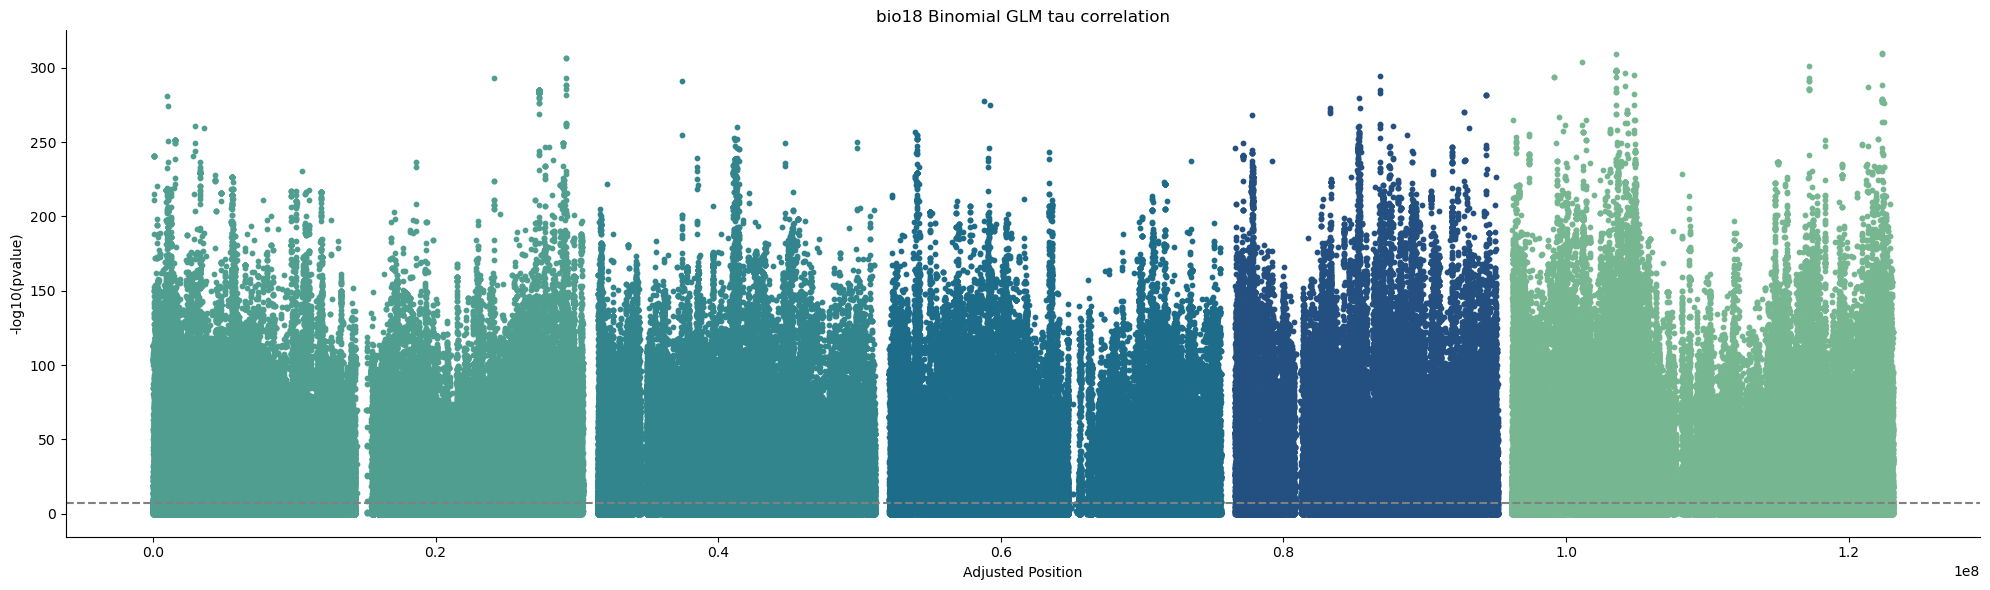

In [5]:
threshold_value = 0.05 / len(binom)

#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = binom[['pvalue', 'pos', 'chrom']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['pvalue'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} Binomial GLM tau correlation')  # Set the title

# Show the plot
plt.tight_layout()
#plt.savefig(f'manhattan_binom_{biovar}.png')
plt.show()

In [28]:
!pwd

/carnegie/nobackup/scratch/tbellagio/gea_grene-net/binomial_regression


In [13]:
binomf = binom.sort_values('pvalue').head(100)

In [16]:
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [20]:
binomf['block'] = binomf['snp_id'].map(reverse_mapping)

In [26]:
binomf = binomf.drop_duplicates('block')

In [ ]:
biovar = 'bio18'

In [27]:
binomf.to_csv(f'top_hits_binom_first_gen_{biovar}.csv')

In [22]:
binomf['block'].unique()

array(['5_3036', '2_664', '1_5116', '4_2320', '5_604', '5_602', '5_648',
       '5_571', '5_447', '5_2402', '5_730', '4_2042', '5_335', '1_4155',
       '5_630', '5_3006', '1_4940', '4_3002'], dtype=object)

In [11]:
import pandas as pd
import argparse
import statsmodels.api as sm
from statsmodels.formula.api import glm
import pickle
import os
import numpy as np

In [12]:
partition = 1 

In [13]:
env_variable = pd.read_csv(f'env_{biovar}.csv')


## get the predict sites 
env_site_test_scaled = pd.read_csv('env_scaled_test.csv')
test_sites = env_site_test_scaled['site'].unique()

partition_0 = pd.read_csv(f'../baypass_first_gen/individual_gfiles/partition_{partition}.txt',header=None) 

pickle_file_path = f'../baypass_first_gen/individual_gfiles/column_names_partition_{partition}'
with open(pickle_file_path, 'rb') as file:
    data0 = pickle.load(file)

partition_0.columns = data0

minor_columns = partition_0.filter(like='minor')
major_columns = partition_0.filter(like='major')

# Properly calculate total allele counts by summing corresponding minor and major allele counts
total_allele_counts = minor_columns.values + major_columns.values

# Create a new DataFrame for total counts with proper column names
total_allele_counts_df = pd.DataFrame(total_allele_counts, columns=minor_columns.columns.str.replace('_minor', '_total'))

minor_alleles = minor_columns.T.reset_index(drop=True)
major_columns = major_columns.T.reset_index(drop=True)

# Total allele counts as the number of trials (total attempts)
total_alleles = total_allele_counts_df.T.reset_index(drop=True)

successes = minor_alleles.iloc[:,1]
failures = major_columns.iloc[:,1]

In [29]:
env_site_test_scaled

,site,env_scaled
0,1,-0.470650
1,2,0.737855
2,3,-0.888056
3,4,1.054310
4,5,0.619698
5,6,0.604667
6,7,-0.329621
7,9,0.118165
8,10,1.946231
9,11,0.492667


In [16]:
X_new

array([[-0.47064966]])

In [33]:
minor_alleles

,0,1,2,3,4,5,6,7,8,9,...,5220,5221,5222,5223,5224,5225,5226,5227,5228,5229
0,115,15,17,17,113,14,115,40,147,119,...,12,12,12,11,92,12,12,10,41,12
1,219,40,54,54,216,44,219,74,279,228,...,14,17,14,14,134,14,14,13,56,14
2,165,23,29,29,163,48,165,71,225,179,...,11,13,11,11,157,11,11,11,68,11
3,215,18,23,23,197,43,212,83,271,220,...,22,24,22,22,166,22,23,22,71,23
4,187,25,33,33,183,30,182,79,269,190,...,16,17,16,16,146,16,16,13,42,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,10,1,1,1,10,8,10,7,17,10,...,2,2,2,2,16,2,2,2,10,2
322,5,0,0,0,5,0,5,0,6,5,...,1,1,1,1,3,1,1,1,1,1
323,29,1,1,1,29,1,30,13,35,29,...,4,4,4,4,11,4,4,3,5,4
324,19,2,2,2,15,4,19,5,26,21,...,6,6,6,6,11,6,6,6,6,6


In [52]:
# Running binomial regression for each SNP separately
coefficients_df = {}

for i in range(minor_alleles.shape[1]):
    # Prepare response (successes, failures) and predictors (environmental variable)
    successes = minor_alleles.iloc[:,i]
    failures = major_columns.iloc[:,i]
    # Set up the binomial regression model
    X = sm.add_constant(env_variable)  # Adding constant for intercept
    y = pd.concat([successes,failures],axis=1)
    # Fit the modelb
    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()

    # Extract slope (coefficient for environmental variable) and p-value
    slope = result.params.iloc[1]  # Coefficient for the environmental variable
    p_value = result.pvalues.iloc[1]  # P-value for the environmental variable
    intercept = result.params.iloc[0]  # Intercept term
    ### predict
    
    for index, row in env_site_test_scaled.iterrows():
        # Predict the probability using the logistic model
        site = row['site']
        X_new = np.column_stack((np.ones(1), np.array([row['env_scaled']])))
        predicted_probability = result.predict(X_new)  # Get the predicted probability
        # Store predictions as a dictionary
        #sites_list.append(site)
        #all_sites_pred_proba.append(predicted_probability[0])
        
        pred = [site,predicted_probability[0],slope,p_value,intercept]
        coefficients_df[str(i) + '_' + str(site)] = pred

In [ ]:
coefficients_df = pd.DataFrame(coefficients_df).T

coefficients_df = coefficients_df.reset_index()

coefficients_df.columns = ['snp','site', 'pred_proba', 'slope', 'pvalue','intercept']

coefficients_df['snp'] = coefficients_df['snp'].str.split('_').str[0]

coefficients_df = coefficients_df.pivot_table(columns = ['site'], values = ['pred_proba'], index= ['snp','slope', 'pvalue', 'intercept']).reset_index()

flat_columns = [
    f"{col[0]}_{int(col[1])}" if isinstance(col[1], float) else col[0]
    for col in coefficients_df.columns
]

coefficients_df.columns = flat_columns

# Ensure the output directory exists
output_dir = f'results_{biovar}/split_{partition}'
os.makedirs(output_dir, exist_ok=True)

coefficients_df['snp'] = coefficients_df['snp'].astype(int)

coefficients_df = coefficients_df.sort_values('snp')
# Save the DataFrame to a CSV file
coefficients_df.to_csv(f'results_{biovar}/split_{partition}/prediction_sites.csv', index=False)



In [ ]:


coefficients_df